# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

!sudo apt-get update && !sudo apt-get install -y python3-opencv

In [105]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Set Arguments & hyperparameters

In [38]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [51]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= 'data'
NUM_CLS = 2

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 10
#TODO : 변경이 필요할 지도.
INPUT_SHAPE = 256

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

shappening

In [106]:
config ={
  "learning_rate": 0.0005,
  "epochs": 30,
  "batch_size": 32,
  "input_shpae": 258
    
}
wandb.init(config = config, project="test-project", entity="team6", name="image-sharppening55-shape256") 

In [99]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        self.sharppening = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

        
        # Loading dataset
        self.db = self.data_loader()
        
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
        

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])
        img = cv2.filter2D(cvimg, -1, self.sharppening)
        
        
        # Preprocessing images
        trans_image = self.transform(Image.fromarray(img))

        return trans_image, data['COVID']


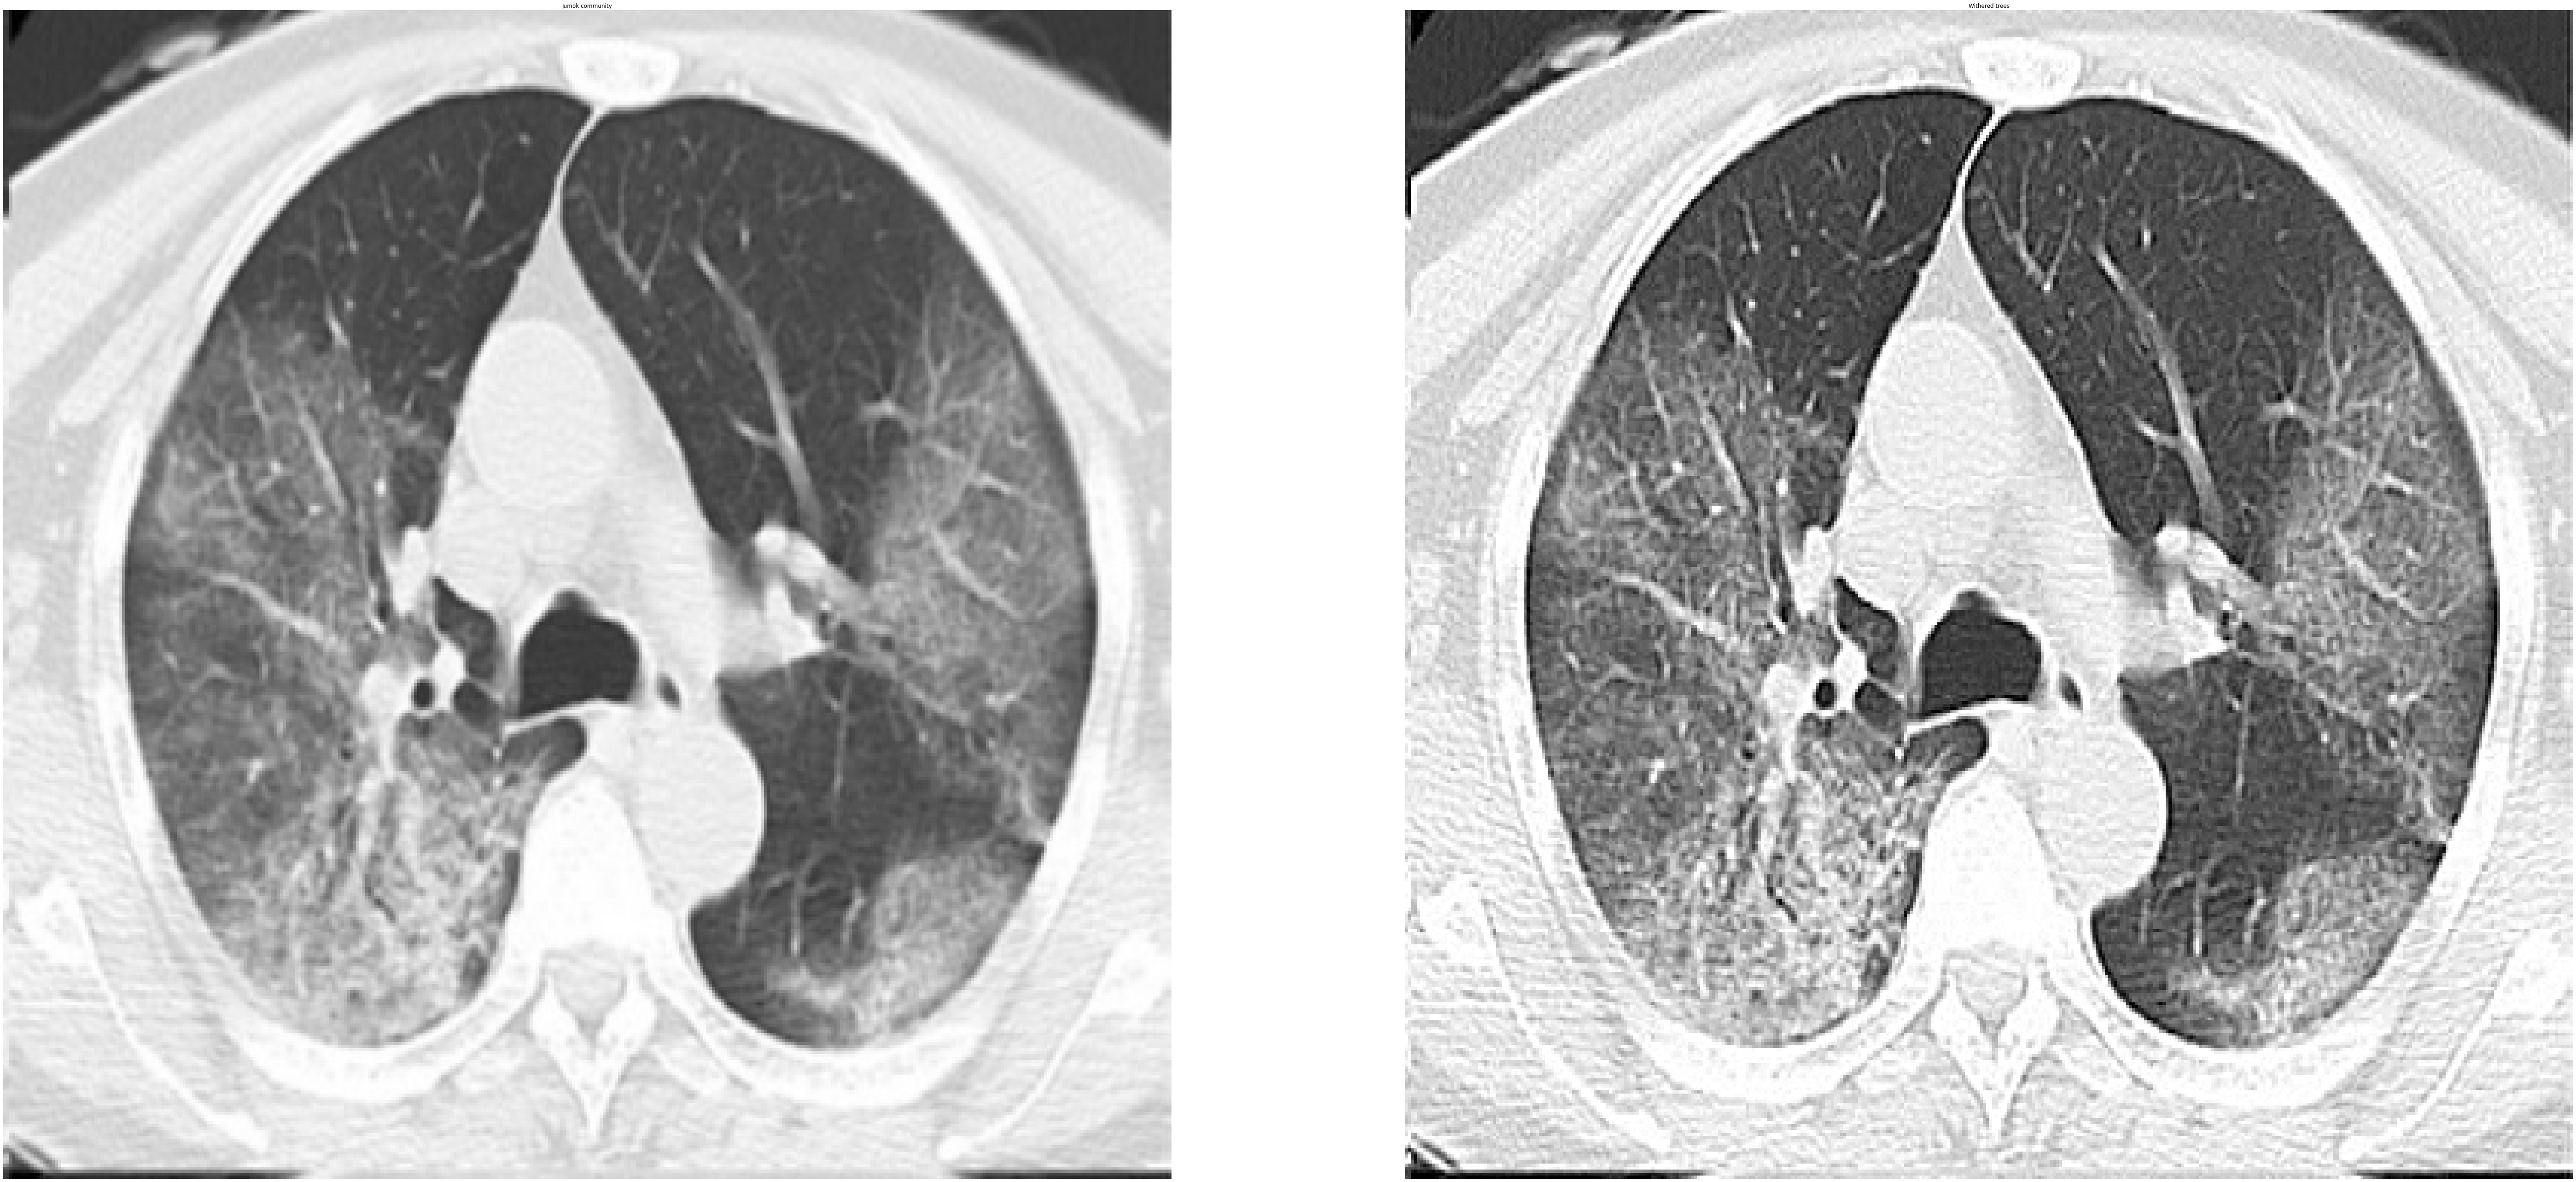

(384, 384, 3) (384, 384, 3)


In [26]:
import matplotlib.pyplot as plt
sharppening = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

cvimg = cv2.imread('/USER/data/train/31.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
img = cv2.filter2D(cvimg, -1, sharppening)
fig = plt.figure(figsize=(100,100))
rows = 1
cols = 2
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB))
ax1.set_title('Jumok community')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Withered trees')
ax2.axis("off")
 
plt.show()

print(cvimg.shape, img.shape)

## Model

In [130]:
class custom_CNN(nn.Module):
    def __init__(self, num_classes):
        super(custom_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=25, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=25, out_channels=50, kernel_size=7)
        
        self.fc1 = nn.Linear(in_features=50*27*27, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        print(x.shape)
        x = self.pool(F.relu(self.conv1(x))) # (32, 3, 128, 128) -> (32, 8, 62, 62)
        print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) # (32, 8, 62, 62) -> (32, 25, 29, 29)
        print(x.shape)
        x = self.pool(F.relu(self.conv3(x))) 
        print(x.shape)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        output = self.softmax(x)
        
        return output

## Utils
### EarlyStopper

In [55]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [19]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        wandb.log({"train_mean_loss": self.train_mean_loss})
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        wandb.log({"train_score": self.train_score})
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        wandb.log({"val_mean_loss": self.val_mean_loss})
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        wandb.log({"val_score": self.validation_score})
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [9]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [101]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 581 Val set samples: 65


#### Load model and other utils

In [131]:
# Load Model
model = custom_CNN(NUM_CLS).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [132]:
model

custom_CNN(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(25, 50, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=36450, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

wandb: Network error (ReadTimeout), entering retry loop.


In [15]:
model.conv2

Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1))

### epoch 단위 학습 진행

In [107]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best_sharp.pt')


  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7217099765936533, Acc: 0.5335628227194492, F1-Macro: 0.34792368125701456


  3% 1/30 [00:55<26:42, 55.24s/it]

Epoch 0, Val loss: 1.050858736038208, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Epoch 1, Train loss: 0.7048152254687415, Acc: 0.5903614457831325, F1-Macro: 0.557198667862175


  7% 2/30 [01:49<25:42, 55.08s/it]

Epoch 1, Val loss: 0.743508592247963, Acc: 0.7230769230769231, F1-Macro: 0.6972049689440994
Validation loss decreased 1.050858736038208 -> 0.743508592247963
Epoch 2, Train loss: 0.6192991187175115, Acc: 0.685025817555938, F1-Macro: 0.683208938547486
Epoch 2, Val loss: 1.0939420014619827, Acc: 0.7384615384615385, F1-Macro: 0.7215923406399596
Early stopping counter 1/10


 10% 3/30 [02:46<24:57, 55.48s/it]

Epoch 3, Train loss: 0.5565490143166648, Acc: 0.7383820998278829, F1-Macro: 0.7376351752822341
Epoch 3, Val loss: 0.48509059101343155, Acc: 0.8923076923076924, F1-Macro: 0.8923076923076922
Validation loss decreased 0.743508592247963 -> 0.48509059101343155


 13% 4/30 [03:42<24:05, 55.60s/it]

Epoch 4, Train loss: 0.5024094863070382, Acc: 0.7848537005163512, F1-Macro: 0.7844219837630052
Epoch 4, Val loss: 0.7694426327943802, Acc: 0.8769230769230769, F1-Macro: 0.8768939393939394
Early stopping counter 1/10


 17% 5/30 [04:36<23:00, 55.21s/it]

Epoch 5, Train loss: 0.44333656628926593, Acc: 0.8244406196213425, F1-Macro: 0.8236459945244614
Epoch 5, Val loss: 1.278548151254654, Acc: 0.8, F1-Macro: 0.7998104714522625
Early stopping counter 2/10


 20% 6/30 [05:33<22:14, 55.60s/it]

Epoch 6, Train loss: 0.4059477415349748, Acc: 0.8209982788296041, F1-Macro: 0.8204189353051665
Epoch 6, Val loss: 0.4444672502577305, Acc: 0.8, F1-Macro: 0.8
Validation loss decreased 0.48509059101343155 -> 0.4444672502577305


 23% 7/30 [06:28<21:16, 55.49s/it]

Epoch 7, Train loss: 0.3380802762177255, Acc: 0.8623063683304647, F1-Macro: 0.8615479935182537
Epoch 7, Val loss: 1.0448135137557983, Acc: 0.8, F1-Macro: 0.795151515151515
Early stopping counter 1/10


 27% 8/30 [07:22<20:13, 55.16s/it]

Epoch 8, Train loss: 0.2999624576833513, Acc: 0.8967297762478486, F1-Macro: 0.8963955395991345
Epoch 8, Val loss: 0.4283228628337383, Acc: 0.8153846153846154, F1-Macro: 0.8153409090909092
Validation loss decreased 0.4444672502577305 -> 0.4283228628337383


 30% 9/30 [08:18<19:25, 55.50s/it]

Epoch 9, Train loss: 0.2587804968158404, Acc: 0.9001721170395869, F1-Macro: 0.8997202713962624
Epoch 9, Val loss: 0.58686463534832, Acc: 0.8, F1-Macro: 0.799239724400095
Early stopping counter 1/10


 33% 10/30 [09:14<18:27, 55.37s/it]

Epoch 10, Train loss: 0.24196671984261936, Acc: 0.9122203098106713, F1-Macro: 0.9118819978290931
Epoch 10, Val loss: 0.48732019402086735, Acc: 0.7692307692307693, F1-Macro: 0.7690120824449184
Early stopping counter 2/10


 37% 11/30 [10:06<17:16, 54.58s/it]

Epoch 11, Train loss: 0.1910576687918769, Acc: 0.927710843373494, F1-Macro: 0.9273126965970833
Epoch 11, Val loss: 0.586350567638874, Acc: 0.7846153846153846, F1-Macro: 0.7845643939393939
Early stopping counter 3/10


 40% 12/30 [11:01<16:22, 54.60s/it]

Epoch 12, Train loss: 0.1602164703524775, Acc: 0.9483648881239243, F1-Macro: 0.9481768231768233
Epoch 12, Val loss: 0.5692747291177511, Acc: 0.7384615384615385, F1-Macro: 0.7362138935306756
Early stopping counter 4/10


 43% 13/30 [11:56<15:29, 54.68s/it]

Epoch 13, Train loss: 0.13202972834308943, Acc: 0.963855421686747, F1-Macro: 0.963716116753156
Epoch 13, Val loss: 0.703752875328064, Acc: 0.7692307692307693, F1-Macro: 0.7690120824449183
Early stopping counter 5/10


 47% 14/30 [12:52<14:41, 55.09s/it]

Epoch 14, Train loss: 0.1257362792061435, Acc: 0.9621342512908778, F1-Macro: 0.9619800590138969
Epoch 14, Val loss: 1.685704618692398, Acc: 0.7384615384615385, F1-Macro: 0.738213693437574
Early stopping counter 6/10


 50% 15/30 [13:49<13:54, 55.66s/it]

Epoch 15, Train loss: 0.09865671541127893, Acc: 0.9793459552495697, F1-Macro: 0.9792791079198269
Epoch 15, Val loss: 0.5404044594615698, Acc: 0.7846153846153846, F1-Macro: 0.7845643939393939
Early stopping counter 7/10


 53% 16/30 [14:45<12:59, 55.68s/it]

Epoch 16, Train loss: 0.0867359187040064, Acc: 0.9862306368330465, F1-Macro: 0.98616172442539
Epoch 16, Val loss: 1.0326516181230545, Acc: 0.7538461538461538, F1-Macro: 0.7537878787878788
Early stopping counter 8/10


 57% 17/30 [15:41<12:07, 55.99s/it]

Epoch 17, Train loss: 0.08283148912919892, Acc: 0.9862306368330465, F1-Macro: 0.9861804861804861
Epoch 17, Val loss: 0.6242245435714722, Acc: 0.8, F1-Macro: 0.7998104714522627
Early stopping counter 9/10


 60% 18/30 [16:37<11:11, 55.96s/it]

Epoch 18, Train loss: 0.0735736975653304, Acc: 0.9913941480206541, F1-Macro: 0.9913531630159453


 60% 18/30 [17:32<11:41, 58.46s/it]

Epoch 18, Val loss: 0.8008975982666016, Acc: 0.7538461538461538, F1-Macro: 0.7509578544061302
Early stopping counter 10/10
Early stopped


## Inference
### 모델 로드

In [126]:
TRAINED_MODEL_PATH = '/USER/custom_sharp_256/best_sharp.pt'

### Load dataset

In [119]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
        self.sharppening = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])


    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])
        img = cv2.filter2D(cvimg, -1, self.sharppening)
        # Preprocessing images
        trans_image = self.transform(Image.fromarray(img))

        return trans_image, data['file_name']

In [120]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, average_precision_score
import seaborn as sns


# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    PR_AUC = average_precision_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d')

In [48]:
get_clf_eval(train_actual, train_pred_lst) # train set
get_clf_eval(validation_actual, validation_pred_lst) # validation set

NameError: name 'train_actual' is not defined

### 추론 진행

In [127]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

1it [00:02,  2.70s/it]

tensor([[1.5845e-01, 8.4155e-01],
        [9.8845e-01, 1.1550e-02],
        [9.3103e-01, 6.8973e-02],
        [4.3189e-02, 9.5681e-01],
        [9.7974e-01, 2.0261e-02],
        [3.0166e-02, 9.6983e-01],
        [7.2032e-01, 2.7968e-01],
        [3.1812e-02, 9.6819e-01],
        [9.9987e-01, 1.3378e-04],
        [1.1204e-05, 9.9999e-01],
        [4.1123e-01, 5.8877e-01],
        [3.5015e-01, 6.4985e-01],
        [6.1923e-01, 3.8077e-01],
        [9.9380e-01, 6.2015e-03],
        [9.8232e-01, 1.7683e-02],
        [9.9121e-01, 8.7907e-03],
        [1.2784e-01, 8.7216e-01],
        [9.8273e-01, 1.7270e-02],
        [1.9369e-01, 8.0631e-01],
        [9.2250e-01, 7.7503e-02],
        [9.8977e-01, 1.0233e-02],
        [9.2472e-01, 7.5276e-02],
        [8.5533e-01, 1.4467e-01],
        [3.4960e-02, 9.6504e-01],
        [9.9376e-01, 6.2412e-03],
        [9.8965e-01, 1.0354e-02],
        [9.9348e-01, 6.5158e-03],
        [7.5278e-01, 2.4722e-01],
        [1.0373e-01, 8.9627e-01],
        [2.048

2it [00:05,  2.66s/it]

tensor([[7.1103e-01, 2.8897e-01],
        [7.8260e-01, 2.1740e-01],
        [9.8726e-01, 1.2739e-02],
        [6.8233e-01, 3.1767e-01],
        [9.2881e-01, 7.1192e-02],
        [2.0820e-03, 9.9792e-01],
        [4.0696e-01, 5.9304e-01],
        [6.8613e-03, 9.9314e-01],
        [6.5885e-03, 9.9341e-01],
        [2.9657e-01, 7.0343e-01],
        [9.5552e-01, 4.4484e-02],
        [3.5349e-02, 9.6465e-01],
        [8.1168e-01, 1.8832e-01],
        [2.0317e-02, 9.7968e-01],
        [7.3219e-02, 9.2678e-01],
        [9.9999e-01, 6.9551e-06],
        [9.2680e-01, 7.3196e-02],
        [4.7029e-01, 5.2971e-01],
        [3.8518e-01, 6.1482e-01],
        [3.6582e-03, 9.9634e-01],
        [5.8791e-01, 4.1209e-01],
        [9.3432e-01, 6.5682e-02],
        [1.9660e-01, 8.0340e-01],
        [2.8863e-01, 7.1137e-01],
        [1.5844e-01, 8.4156e-01],
        [1.4047e-02, 9.8595e-01],
        [9.9765e-01, 2.3454e-03],
        [1.2118e-02, 9.8788e-01],
        [1.2927e-02, 9.8707e-01],
        [9.637

4it [00:07,  1.89s/it]

tensor([[5.2011e-03, 9.9480e-01],
        [7.6945e-04, 9.9923e-01],
        [1.7407e-01, 8.2593e-01],
        [8.4949e-01, 1.5051e-01],
        [1.2067e-02, 9.8793e-01],
        [9.5045e-01, 4.9549e-02],
        [8.9571e-01, 1.0429e-01],
        [9.6532e-01, 3.4679e-02],
        [9.9556e-01, 4.4405e-03],
        [9.9705e-01, 2.9534e-03],
        [2.7874e-03, 9.9721e-01],
        [9.9998e-01, 1.8163e-05],
        [9.9634e-01, 3.6623e-03],
        [4.6664e-01, 5.3336e-01],
        [2.1022e-01, 7.8978e-01],
        [3.3087e-01, 6.6913e-01],
        [7.7781e-02, 9.2222e-01],
        [9.9177e-01, 8.2265e-03],
        [9.5922e-01, 4.0780e-02],
        [3.4921e-02, 9.6508e-01],
        [8.9663e-02, 9.1034e-01],
        [8.8758e-01, 1.1242e-01],
        [2.3204e-01, 7.6796e-01],
        [9.6003e-01, 3.9969e-02],
        [9.2568e-01, 7.4322e-02],
        [4.8392e-01, 5.1608e-01],
        [9.3013e-01, 6.9872e-02],
        [9.3573e-01, 6.4265e-02],
        [8.3903e-01, 1.6097e-01],
        [4.977

4it [00:08,  2.01s/it]


### 결과 저장

In [128]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('custom_sharp_256/prediction.csv', index=False)